In [38]:
from scipy.io import mmread
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spilu,spsolve_triangular
from scipy.sparse import tril


In [39]:
# Function to create matrix B
def generate_vector_b(n):
    b = np.zeros(n)
    b[0] = 1
    return b


In [40]:
A = mmread('gyro_k.mtx')

In [41]:
n= A.shape[0]
b= generate_vector_b(n)

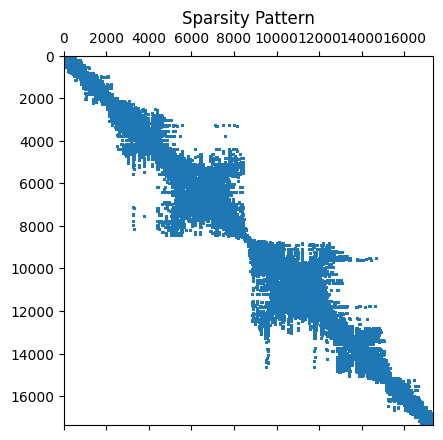

In [42]:
plt.spy(A, markersize=1)
plt.title("Sparsity Pattern")
plt.show()


In [43]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

# Convert A to a sparse matrix
A_sparse = csr_matrix(A)

# Estimate the condition number using sparse SVD
u, s, vt = svds(A_sparse, k=2)  # Compute the largest and smallest singular values
condition_number = s[-1] / s[0]  # s[-1]: smallest, s[0]: largest
print("Condition number (sparse):", condition_number)


Condition number (sparse): 1.202939011268885


In [44]:
def prebuilt_ichol(A):
    """
    Perform Incomplete Cholesky factorization using a pre-built method from scipy.
    """
    # Convert to CSC format as spilu works with CSC matrices
    A_csc = A.tocsc()
    
    try:
        # Perform Incomplete LU (Cholesky equivalent for SPD matrices)
        ichol_factor = spilu(A_csc, drop_tol=1e-5, fill_factor=10)
        L = ichol_factor.L  # Extract the lower triangular part
        return tril(L, format='csr')  # Return as lower triangular CSR
    except Exception as e:
        raise RuntimeError(f"Incomplete Cholesky factorization failed: {e}")


In [45]:
def conjugate_gradient_with_preconditioning(A, b,max_iter, x0=None, tol=1e-6, verbose=False):
    if x0 is None:
        x0 = np.zeros_like(b)
    x = x0.copy()
    
    # Compute incomplete Cholesky factorization (Preconditioner)
    L = prebuilt_ichol(A)
    
    # Initial residual
    r = b - A @ x
    
    # Apply preconditioner: Solve L y = r
    y = spsolve_triangular(L, r, lower=True)
    # Then solve L^T z = y
    z = spsolve_triangular(L.T, y, lower=False)
    
    p = z.copy()
    rs_old = np.dot(r.T, z)
    
    if np.sqrt(rs_old) < tol:  # Initial guess is the solution
        if verbose:
            print("Initial guess is the solution.")
        return x, [np.sqrt(rs_old)], [x], 0
    
    residuals = [np.sqrt(np.dot(r.T, r))]
    solutions = [x.copy()]
    
    for i in range(max_iter):
        Ap = A @ p
        alpha = rs_old / np.dot(p.T, Ap)
        x += alpha * p
        r -= alpha * Ap
        
        # Apply preconditioner to the new residual
        y = spsolve_triangular(L, r, lower=True)
        z = spsolve_triangular(L.T, y, lower=False)
        
        rs_new = np.dot(r.T, z)
        
        residuals.append(np.sqrt(np.dot(r.T, r)))
        solutions.append(x.copy())
        
        if np.sqrt(np.dot(r.T, r)) < tol:
            if verbose:
                print(f"Converged in {i + 1} iterations with residual norm {np.sqrt(np.dot(r.T, r)):.2e}.")
            break
        
        beta = rs_new / rs_old
        p = z + beta * p
        rs_old = rs_new
    else:
        if verbose:
            print(f"Did not converge within {max_iter} iterations. Final residual norm: {np.sqrt(np.dot(r.T, r)):.2e}")
    
    return x, residuals, solutions, i + 1

In [46]:
x0 = np.random.rand(n)

In [47]:
solution, residuals, solutions, iterations = conjugate_gradient_with_preconditioning(A, b,max_iter=n ,x0=x0, verbose=True)

Did not converge within 17361 iterations. Final residual norm: 1.07e+05


In [10]:
# List to track iterations
iteration_count = []

def callback(xk):
    iteration_count.append(1)

In [53]:
from scipy.sparse.linalg import LinearOperator

M = LinearOperator(A.shape, lambda x: x / A.diagonal())  # Jacobi preconditioner
x, info = cg(A, b, M=M,callback=callback)


In [54]:
residual = b - A @ x
error_norm = np.linalg.norm(residual)
print("Residual norm:", error_norm)
print("no itterartion:", len(iteration_count))


Residual norm: 9.968416102662072e-06
no itterartion: 12460


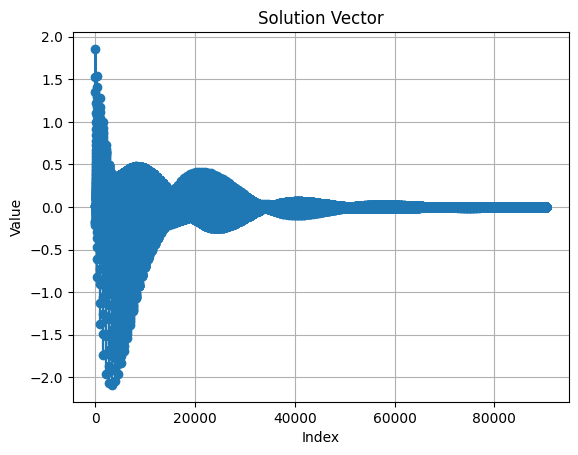

In [60]:
plt.plot(x, marker='o', linestyle='-')
plt.title("Solution Vector")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()


In [61]:
B = mmread('gyro_k.mtx')

In [62]:
n_b = B.shape[0]
b_b= generate_vector_b(n_b)

In [70]:
from scipy.sparse.linalg import LinearOperator

M_b = LinearOperator(B.shape, lambda x: x / B.diagonal())  # Jacobi preconditioner
x_b, info_b = cg(B, b_b, M=M_b)

In [71]:
residual_b = b_b - B @ x_b
error_norm_b = np.linalg.norm(residual_b)
print("Residual norm:", error_norm_b)


Residual norm: 9.974626460543845e-06


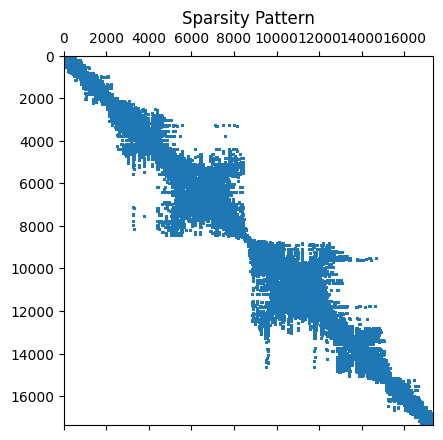

In [72]:
plt.spy(B, markersize=1)
plt.title("Sparsity Pattern")
plt.show()

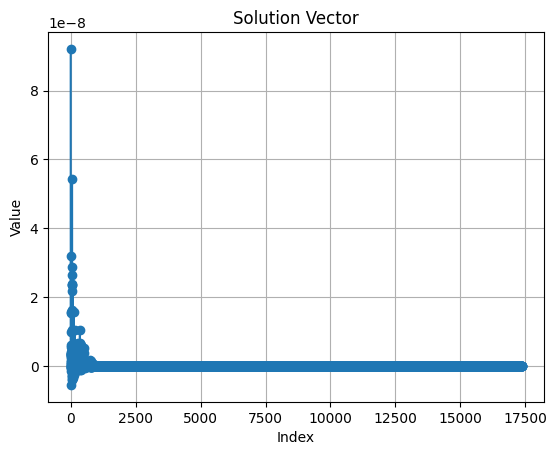

In [73]:
#x_b = np.round(x_b,4)
plt.plot(x_b, marker='o', linestyle='-')
plt.title("Solution Vector")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()